# Chapter 2 - 分類問題

分類問題に

- **パーセプトロン** (perceptron)
- **ADALINE** (Adaptive Linear Neuron)

を適用する.

## パーセプトロン

- **McCulloch-Pitts (MCP)ニューロン** (1943).
    - 二値出力を行う単純な論理ゲート. 蓄積された信号が特定の閾値を超えた場合は, 出力信号が生成され, 伝達される.
- Rosenblatt, MCPニューロンに基づくパーセプトロンの学習規則 (1957).
    - 最適な重み係数を自動的に学習した後, 入力信号と掛け合わせ, ニューロンが発火するかどうかを判断するアルゴリズムの提案.

パーセプトロンを用いて分類問題を解いてみる.

- 分類問題: サンプルが二つのクラスのどちらに属するかを予測する問題.
    - 陽性クラスを1, 陰性クラスを-1とする.
- **活性化関数** (activation function) として, 閾値 $\theta$ のHeaviside関数を使う:
    $$
        \phi (z) \triangleq \begin{cases} 1 & (z \ge \theta) \\ -1 & (z < \theta) \end{cases}
    $$
    - $z$ は, 入力 $x = (x_1, \dots, x_m)^{\top}$ と重み $w = (w_1, \dots, w_m)^{\top}$ についての総入力:
    $$
        z = \sum_{i=1}^{m} w_ix_i = w^{\top}x.
    $$
    - $w_0 = - \theta$, $x_0 = 1$ として, 改めて $w = (w_0, \dots, w_m)^{\top}$, $x = (x_0, \dots, x_m)^{\top}$ とすれば, 
    $$
        \phi (z) = \begin{cases} 1 & (z \ge 0) \\ -1 & (z < 0) \end{cases}, ~~ z = w^{\top}x.
    $$
    - $\phi (w^{\top}x) = 0$ を境界に, クラス1とクラス-1とを分離.

### Rosenblattのパーセプトロンの初期の学習規則

1. 重みを0または値の小さい乱数で初期化.
2. トレーニングサンプル $x^{(i)}$ ごとに以下の手順を実行:
    1. 出力値 $\hat{y} \in \{1, -1\}$ を計算.
    2. 重み $w$ を以下の式で更新:
    $$
        w := w + \Delta w, ~~ \Delta w = \eta (y^{(i)} - \hat{y}^{(i)})x^{(i)}.
    $$
        - $\eta \in (0, 1]$: 学習率.
        - $y^{(i)}$: $i$ 番目のサンプルの真のラベル.
        - $\hat{y}^{(i)}$: $i$ 番目のサンプルの予測されたラベル.
3. すべてのサンプルが正しく分類されるようになれば, アルゴリズム終了. そうでないなら2に戻る.

### 動作の特徴

- 重みの修正について:
    - 予測が正しければ, 重みは変化しない.
    - 予測が正しくなければ, 重みは正しいクラスに向かうように修正される.
- 収束性について:
    - 二つのクラスが線形分離可能で, 学習率が十分小さいときに限り, パーセプトロンの収束が保証される.
    - 線形分離不可能な時は, データセットに対するトレーニングの最大回数 (エポック) や, 誤分類の最大数を設定することで, 無限ループを回避.

以下のコードが, パーセプトロンの学習規則を実装したもの.

In [1]:
import numpy as np


class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self.w_ = np.zeros(1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

具体例として, pandasを用いてFisherのアヤメデータセットを読み込む.

In [2]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


分類のラベルを-1, 1に変換したものを `y`, 表から萼片の長さと花弁の長さのデータを抽出して作った特徴行列を `X` とする.
分布を図示してみる.

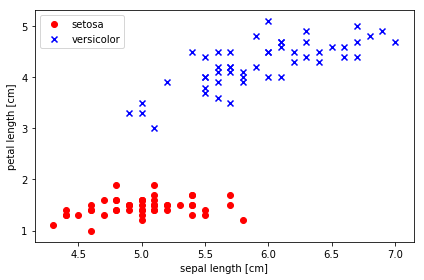

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# select setosa and versicolor
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

# extract sepal length and petal length
X = df.iloc[0:100, [0, 2]].values

# plot data
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='x', label='versicolor')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('./images/02_06.png', dpi=300)
plt.show()

見たところ線形分離可能らしい.

このデータセットで, パーセプトロンのアルゴリズムを用いて決定境界を見つける.
アルゴリズムの収束性を確かめるため, 各エポックの誤分類の個数をプロットしてみる.

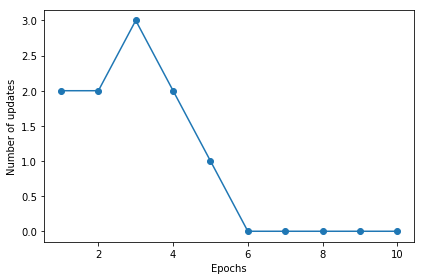

In [4]:
ppn = Perceptron(eta=0.1, n_iter=10)

ppn.fit(X, y)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

plt.tight_layout()
# plt.savefig('./perceptron_1.png', dpi=300)
plt.show()

6回目で収束している.
トレーニングサンプルを完全に分類できるようになっている.

2次元データセットの決定境界の可視化のために, 以下の関数を定義.

In [6]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

プロットしてみる.

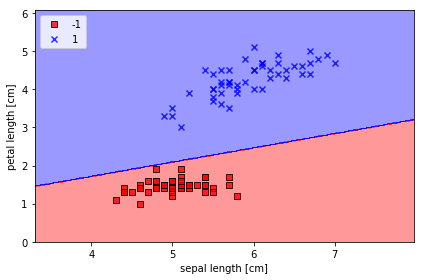

In [7]:
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./perceptron_2.png', dpi=300)
plt.show()

ちゃんと分離できていて大変めでたい.

## ADALINE

- **ADALINE**: Widrow, Hoffによるパーセプトロンアルゴリズムの改良 (1960).
- パーセプトロンとの主な違い: 重みの更新方法.
    - パーセプトロン: Heaviside関数を用いて判定したラベルに基づいて重みが更新.
    - ADALINE: 線形活性化関数 $\phi (w^{\top}x) = w^{\top}x$ (恒等関数) の出力する連続値に基づいて重みが更新.
- クラスラベルの予測には, **量子化器** (quantizer) を用いる.
    - Heaviside関数である.

## 勾配降下法

- 教師あり機械学習のアルゴリズムでは, 学習過程で最適化される **目的関数** (objective function) を定義することがある.
    - 多くの場合は, 最小化したい **コスト関数** (cost function) が目的関数に選ばれる.
        - ADALINEでは, 重みの学習に用いるコスト関数 $J$ を, 計算結果と真のクラスラベルとの残差平方和として
        $$
            J(w) \triangleq \frac{1}{2} \sum_{i = 1}^{n} (\phi(w^{\top}x^{(i)}) - y^{(i)})^2 = \frac{1}{2} \| X w - y \|^2 
        $$
        と定義できる.
        ただし, $X = (x^{(1)}, \dots, x^{(n)})^{\top}$, $y = (y^{(1)}, \dots, y^{(n)})^{\top}$
        - このコスト関数は $w$ について微分可能で, かつ凸関数になっている.<br />
        → 勾配降下法を利用して, コスト関数を最小化する重みを求められる.

- **勾配降下法** (gradient descent): コストが局所的, または大域的最小値に達するまで, 勾配 (傾きが最も急な方向) に沿って "坂を下る".
    - 反復のたびに, 勾配に沿って1ステップ進む. 進む距離は, 勾配の傾きと, 学習率によって決定される.

ADALINEにおける勾配降下法による重みの更新は, 学習率を $\eta$ として次の通り:
$$
    w := w + \Delta w, ~~ \Delta w = - \eta \nabla J(w).
$$
ここで, $\nabla J(w) = X^{\top} (Xw - y)$ であるから, 結局, 
$$
    w := w - \eta X^{\top} (Xw - y).
$$

### 動作の特徴

- トレーニングデータセット全体を用いて ($X = (x^{(1)}, \dots, x^{(n)})^{\top}$ はトレーニングデータセット全体から作られた行列である) 重みを計算している.


In [8]:
class AdalineGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    cost_ : list
        Sum-of-squares cost function value in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            # Please note that the "activation" method has no effect
            # in the code since it is simply an identity function. We
            # could write `output = self.net_input(X)` directly instead.
            # The purpose of the activation is more conceptual, i.e.,  
            # in the case of logistic regression, we could change it to
            # a sigmoid function to implement a logistic regression classifier.
            output = self.activation(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

ADALINEの学習率 $\eta$ は **ハイパーパラメータ** (hyperparameter) であり, 最適な学習率を見つけるにはある程度実験が必要.
二つの学習率 $\eta = 0.01$ と $\eta = 0.0001$ で, コスト関数の値とエポック数をプロットし, どの程度効果的に学習するかを確認する.

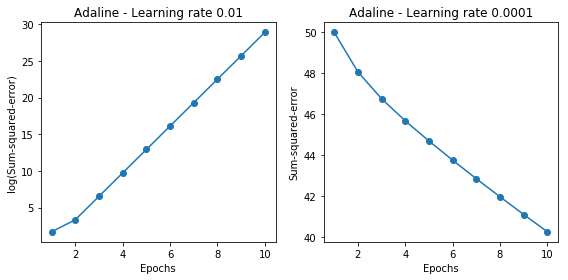

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Learning rate 0.0001')

plt.tight_layout()
# plt.savefig('./adaline_1.png', dpi=300)
plt.show()

- $\eta = 0.01$ のときは, エポック数を重ねるごとに誤差が大きくなっている.<br />
  → 学習率が大きすぎるため, 大域最小値を超えてしまう.
- $\eta = 0.0001$ のときは, エポック数を重ねるごとに誤差が小さくなっている.
    - ただし, これは小さすぎるため, アルゴリズムの収束には相当な数のエポック数が必要.

- 機械学習のアルゴリズムで最適なパフォーマンスを実現するにあたって, 特徴量のスケーリングをすることが多い.
    - 勾配降下法は, 特徴量のスケーリングに効果的なアルゴリズムの一つ.
- 標準化: スケーリング手法の一つ. 各特徴量の平均を0, 分散を1にする方法.
    - $j$ 番目の特徴量 $x_j$ を標準化すると
    $$
        x'_j = \frac{x_j - \mu_j}{\sigma_j}
    $$
    となる.

標準化してみる.

In [12]:
# standardize features
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

**Memo**: <br />
`X_std = np.copy(X)` で `X` の内容を `X_std` にディープコピーしている.
`X_std` の内容を変更しても, `X` は変更を受けない.
一方, `X_std = X` とするとシャローコピーとなり, `X_std` を変更すると `X` も変更されてしまう.

標準化したので, 学習率 $\tea = 0.01$ のADALINEでトレーニングし, 収束することを確認する.

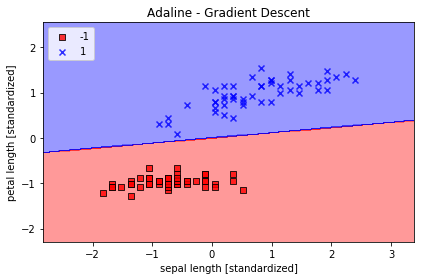

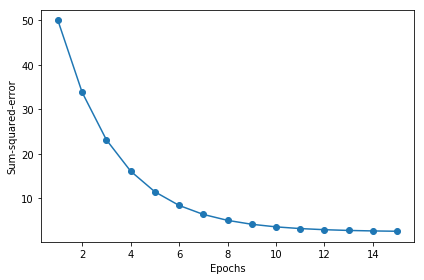

In [13]:
ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./adaline_2.png', dpi=300)
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
# plt.savefig('./adaline_3.png', dpi=300)
plt.show()

イケてる.
すべてのサンプルが正しく分類されているが, 残差平方和は0にはなっていない.

## 大規模な機械学習と確率的勾配降下法

- トレーニングデータセットが大きくなると, 勾配降下法における $X$ が大規模行列になる.<br />
  → ステップごとにトレーニングデータ全体を再び評価するのは, 計算コストがかなりかかる可能性がある.
- **確率的勾配降下法** (stochastic gradient descent): 勾配降下法で, 重みの更新量 $\Delta w$ を
    $$
        \Delta w = \eta (y^{(i)} - w^{\top}x^{(i)}) x^{(i)}
    $$
    とする.
    - 勾配降下法の近似とみなせる.
    - 重みの更新頻度が勾配降下法より高いので, 通常ははるかに高速に収束する.
    - 勾配は, それぞれ一つのトレーニングサンプルに基づいて計算されているので, 勾配降下法より誤差曲面のノイズが多い.
        - 確率的勾配降下法のほうが, 浅い極小値を簡単に抜け出せる.<br />
    - 正確な結果を得るには, データをランダムな順序に並べ替えるのが重要.
        - エポックごとにトレーニングデータをシャッフルして, 重み $w$ が同じ値に戻ってしまうのを避ける.
    - 大域的最小解に収束しないが, それにかなり近い場所で収束する.
    - 実装では, $k$ を反復回数, $c_1, c_2$ を定数として, 学習率 $\eta$ を
        $$
            \eta = \frac{c_1}{k + c_2}
        $$
      などの徐々に減少する **適応学習率** (adaptive learning rate) にすることが多い.
      これを用いることで, 固定の学習率を用いるよりも大域的最小解にさらに近づけることができる.
    - **オンライン学習** (online learning) に利用することができる.
        - 新しいトレーニングデータが届いたときに, その場でモデルがトレーニングされる.
        - データが大量にあるとき, データ数が増えやすいときに利用.

- **ミニバッチ学習** (mini-batch learning): 勾配降下法と確率的勾配降下法の折衷案.
  一部のトレーニングデータを使って勾配降下法を適用する.
    - 全部のトレーニングデータを用いるのが勾配降下法, 一つのトレーニングデータを用いるのが確率的勾配降下法.
    - 勾配降下法よりも重みの更新頻度が高いので, 収束が速い.

確率的勾配降下法で学習を行ってみる.

In [14]:
from numpy.random import seed

class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    cost_ : list
        Sum-of-squares cost function value averaged over all
        training samples in each epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to zeros"""
        self.w_ = np.zeros(1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.net_input(xi)
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

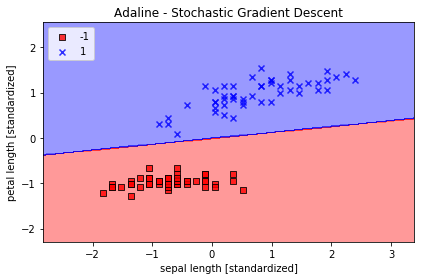

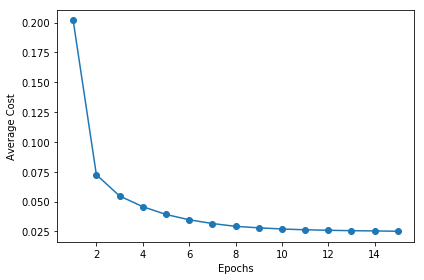

In [15]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('./adaline_4.png', dpi=300)
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')

plt.tight_layout()
# plt.savefig('./adaline_5.png', dpi=300)
plt.show()